# Timeseries classification from scratch


## Introduction

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [3]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3601, 500) (3601,)
(1320, 500) (1320,)


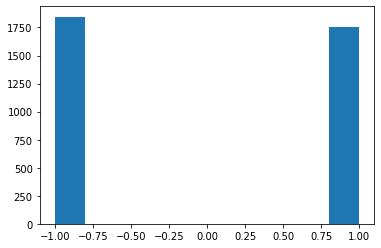

In [4]:
plt.figure()
plt.hist(y_train)
plt.show()

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

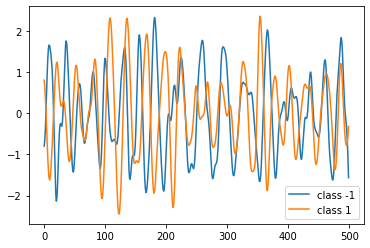

In [5]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries are already in a single length (500). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test  = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [7]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [8]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [9]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

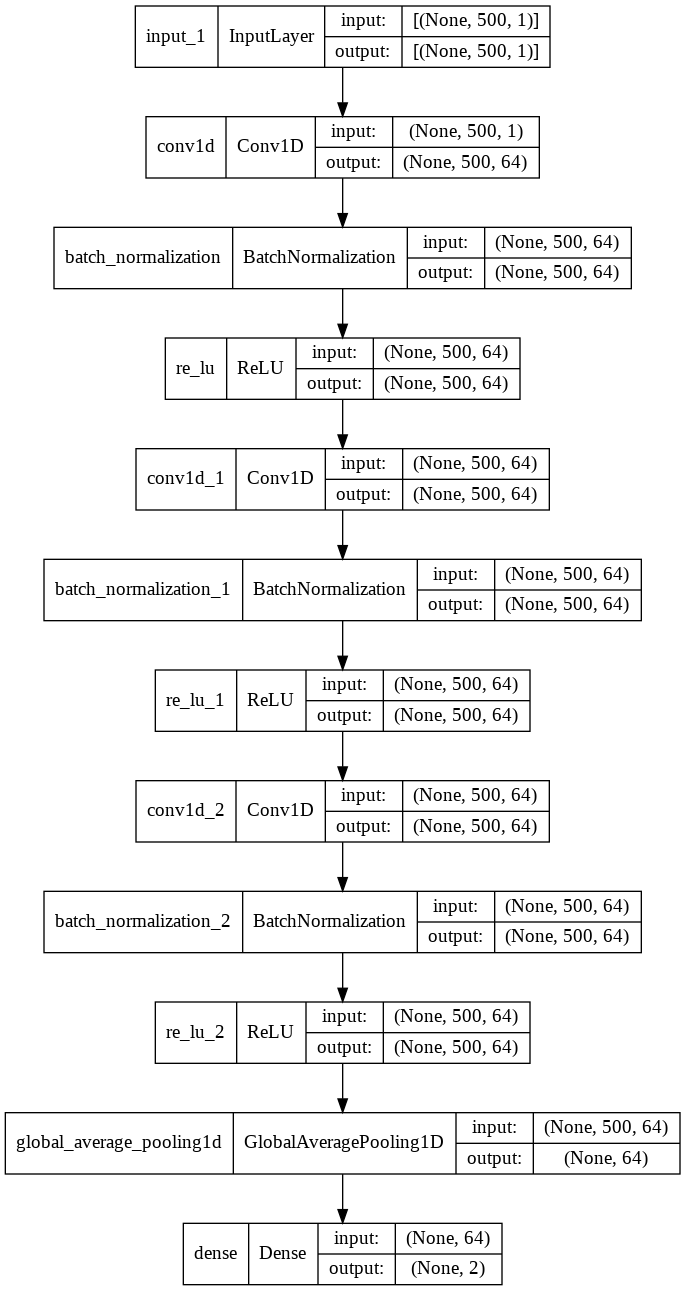

In [10]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [11]:
#-------------------------------------------------------------------------------
epochs     = 500
batch_size = 32
#-------------------------------------------------------------------------------
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
#-------------------------------------------------------------------------------
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)
#-------------------------------------------------------------------------------

Epoch 1/500
90/90 [==============================] - 11s 18ms/step - loss: 0.5617 - sparse_categorical_accuracy: 0.6993 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.5257 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 1s 13ms/step - loss: 0.4789 - sparse_categorical_accuracy: 0.7569 - val_loss: 0.7699 - val_sparse_categorical_accuracy: 0.5257 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 1s 14ms/step - loss: 0.4360 - sparse_categorical_accuracy: 0.7851 - val_loss: 0.7014 - val_sparse_categorical_accuracy: 0.5229 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 1s 14ms/step - loss: 0.4168 - sparse_categorical_accuracy: 0.7885 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.5839 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 1s 13ms/step - loss: 0.4190 - sparse_categorical_accuracy: 0.7896 - val_loss: 0.7547 - val_sparse_categorical_accuracy: 0.5520 - lr: 0.0010
Epoch 6/500
90/90 [===============

## Evaluate model on test data

In [13]:
best_model = keras.models.load_model("best_model.h5")

test_loss, test_acc = best_model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 1s 7ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.9659
Test accuracy 0.9659090638160706
Test loss 0.10014396160840988


## Plot the model's training and validation loss

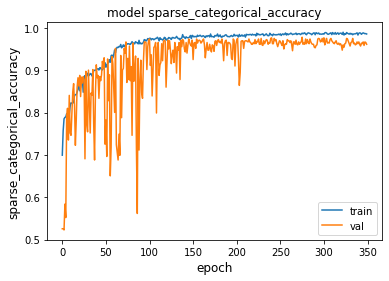

In [14]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.

# Multi-Scale CNN

With this simple example in mind, let’s examine the model of a multi-scale convolutional neural network for time series classification [MSCNN](https://arxiv.org/abs/1603.06995).
The multi-scalability of this model consists in its architecture: in the first convolutional layer the convolution is performed on 3 parallel independent branches. Each branch extracts features of different nature from the data, operating at different time and frequency scales.
The framework of this network consists of 3 consecutive stages: transformation, local convolution, and full convolution.

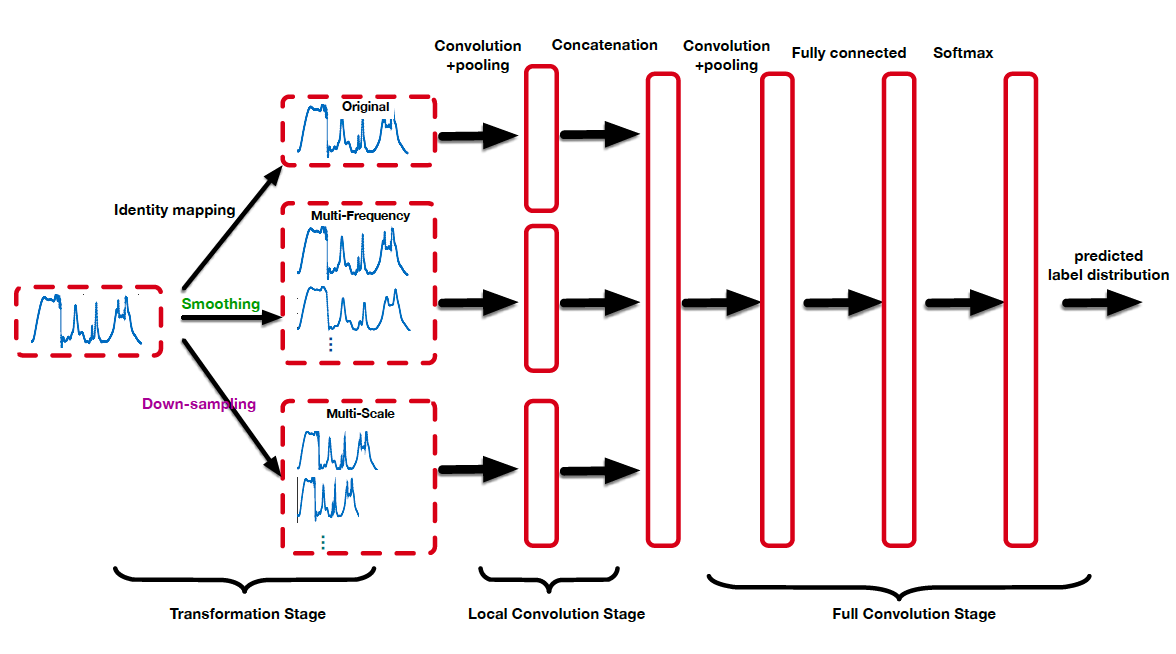



*   **Transformation**: 

    On this stage different transformations are applied to the original time series on 3 separate branches. The first branch transformation is identity mapping, meaning that the original time series remains intact.
The second branch transformation is smoothing the original time series with a moving average with various window sizes. This way, several new time series with different degrees of smoothness are created. The idea behind this is that each new time series consolidates information from different frequencies of the original data.
Finally, the third branch transformation is down-sampling the original time series with various down-sampling coefficients. The smaller the coefficient, the more detailed the new time series is, and, therefore, it consolidates information about the time series features on a smaller time scale. Down-sampling with larger coefficients results in less detailed new time series which capture and emphasize those features of the original data that exhibit themselves on larger time scales.
*   **Local Convolution**:

  On this stage the 1-D convolution with different filter sizes that we discussed earlier is applied to the time series. Each convolutional layer is followed by a max-pooling layer. In the previous, simpler example global max pooling was used. Here, max pooling is not global, but still the pooling kernel size is extremely large, much larger than the sizes you are used to when working with image data. More specifically, the pooling kernel size is determined by the formula n/p, where n is the length of the time series, and p is a pooling factor, typically chosen between the values {2, 3, 5}. This stage is called local convolution because each branch is processed independently.

* **Full Convolution**

  On this stage all the outputs of local convolution stage from all 3 branches are concatenated. Then several more convolutional and max-pooling layers are added. After all the transformations and convolutions, you are left with a flat vector of deep, complex features that capture information about the original time series in a wide range of frequency and time scale domains. This vector is then used as an input to fully connected layers with Softmax function on the last layer.

In [15]:
import numpy as np


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [16]:
from scipy import signal
x_train = x_train
downsampled_1 =  signal.resample(x_train.T,250).T
downsampled_2 =  signal.resample(x_train.T,125).T
#
x_test = x_test
test_downsampled_1 =  signal.resample(x_test.T,250).T
test_downsampled_2 =  signal.resample(x_test.T,125).T

In [17]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
downsampled_1 = downsampled_1.reshape((downsampled_1.shape[0], downsampled_1.shape[1], 1))
downsampled_2 = downsampled_2.reshape((downsampled_2.shape[0], downsampled_2.shape[1], 1))
#
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
test_downsampled_1 = test_downsampled_1.reshape((test_downsampled_1.shape[0], test_downsampled_1.shape[1], 1))
test_downsampled_2 = test_downsampled_2.reshape((test_downsampled_2.shape[0], test_downsampled_2.shape[1], 1))

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model
#this base model is one branch of the main model
#it takes a time series as an input, performs 1-D convolution, and returns it as an output ready for concatenation
def get_base_model(input_len, fsize):
  #the input is a time series of length n and width 19
  input_seq = Input(shape=(input_len, 1))
  #choose the number of convolution filters
  nb_filters = 10
  #1-D convolution and global max-pooling
  convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
  processed = GlobalMaxPooling1D()(convolved)
  #dense layer with dropout regularization
  compressed = Dense(50, activation="tanh")(processed)
  compressed = Dropout(0.3)(compressed)
  model = Model(inputs=input_seq, outputs=compressed)
  return model
#this is the main model
#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
def main_model(inputs_lens = [125, 250, 500], fsizes = [8,16,24]):
  #the inputs to the branches are the original time series, and its down-sampled versions
  input_smallseq = Input(shape=(inputs_lens[0], 1))
  input_medseq = Input(shape=(inputs_lens[1] , 1))
  input_origseq = Input(shape=(inputs_lens[2], 1))
  #the more down-sampled the time series, the shorter the corresponding filter
  base_net_small = get_base_model(inputs_lens[0], fsizes[0])
  base_net_med = get_base_model(inputs_lens[1], fsizes[1])
  base_net_original = get_base_model(inputs_lens[2], fsizes[2])
  embedding_small = base_net_small(input_smallseq)
  embedding_med = base_net_med(input_medseq)
  embedding_original = base_net_original(input_origseq)
  #concatenate all the outputs
  merged = Concatenate()([embedding_small, embedding_med, embedding_original])
  out = Dense(2, activation='softmax')(merged)
  model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
  keras.utils.plot_model(model, show_shapes=True)
  return model

In [19]:
model = main_model()

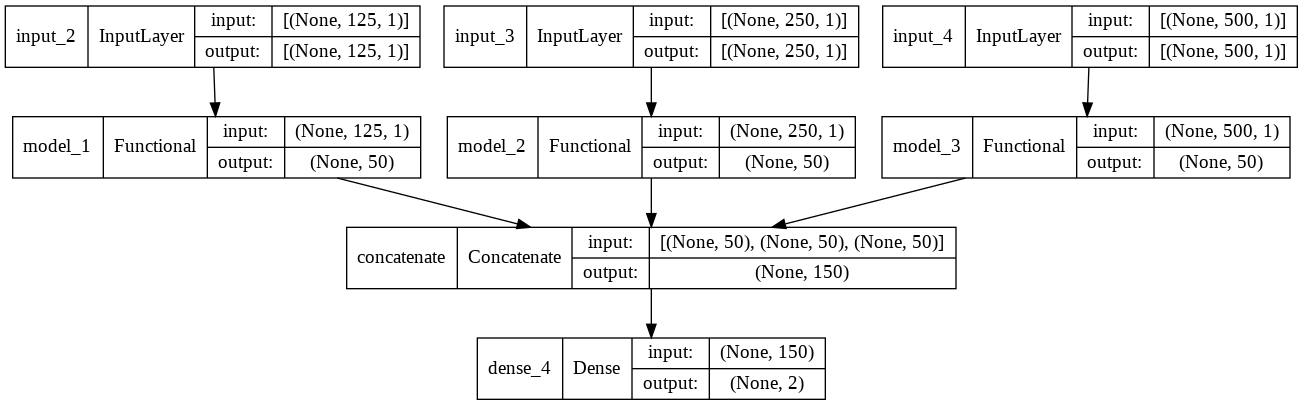

In [20]:
keras.utils.plot_model(model, show_shapes=True)

In [21]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 125, 1)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 model_1 (Functional)           (None, 50)           640         ['input_2[0][0]']                
                                                                                            

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=['Accuracy'])

In [23]:
XTr = [downsampled_2,downsampled_1,x_train]

model.fit(XTr, y_train,epochs=10)

Epoch 1/10
113/113 [==============================] - 2s 8ms/step - loss: 0.6634 - Accuracy: 0.6046
Epoch 2/10
113/113 [==============================] - 1s 7ms/step - loss: 0.4723 - Accuracy: 0.8123
Epoch 3/10
113/113 [==============================] - 1s 8ms/step - loss: 0.3551 - Accuracy: 0.8609
Epoch 4/10
113/113 [==============================] - 1s 7ms/step - loss: 0.3020 - Accuracy: 0.8817
Epoch 5/10
113/113 [==============================] - 1s 8ms/step - loss: 0.2727 - Accuracy: 0.8900
Epoch 6/10
113/113 [==============================] - 1s 7ms/step - loss: 0.2596 - Accuracy: 0.8948
Epoch 7/10
113/113 [==============================] - 1s 8ms/step - loss: 0.2549 - Accuracy: 0.8975
Epoch 8/10
113/113 [==============================] - 1s 7ms/step - loss: 0.2511 - Accuracy: 0.8928
Epoch 9/10
113/113 [==============================] - 1s 7ms/step - loss: 0.2448 - Accuracy: 0.8961
Epoch 10/10
113/113 [==============================] - 1s 8ms/step - loss: 0.2399 - Accuracy: 0.9017

In [24]:
XTs = [test_downsampled_2,test_downsampled_1,x_test]
y_pred = model.predict(XTs)
y_pred = np.argmax(y_pred,axis=1)
print('Test Accuracy:',np.mean(y_pred==y_test)*100)

Test Accuracy: 91.06060606060606


It takes the original time series and 2 down-sampled versions of it (medium and small length) as an input. The first branch of the model processes the original time series of length 500 and of width 1. The corresponding convolution filter length is 24. The second branch processes the medium-length (250 timesteps) down-sampled version of the time series, and the filter length used here is 16. The third branch processes the shortest version (125 timesteps) of the time series, with the filter length of 8. This way every branch extracts features on different time scales.
After convolutional and global max-pooling layers, dropout regularization is added, and all the outputs are concatenated. The last fully connected layer returns the result of classification.